<a href="https://colab.research.google.com/github/nicoeiris11/rl-qlearning-sarsa/blob/master/TemporalDifferences_Nicolas_Eiris_182713.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Métodos de Diferencias Temporales (TD)

En este notebook vamos a ver métodos de diferencias temporales en particular, vamos a ver un método de control on-policy (Sarsa) y un método off-policy (Q-Learning) para estimar la funcion de valor (y la política) ótima para un problema. 


El notebook se basa en el capítulo 6 del libro de Sutton y Barto.


****

## Ambiente

Vamos a utilizar un problema clásico de Reinforcement Learning, y para ello vamos a usar otro ambiente de OpenAi gym: MountainCar: https://gym.openai.com/envs/MountainCar-v0/.

La descripcion del mismo es la siguiente:

Un auto esta posicionado en un carril de una dimension entre dos montañas. El objetivo es llegar a la cima de la montaña derecha pero, el motor del auto no es lo suficientemente fuerte para hacerlo en una sola pasada (no puede simplemente acelerar y llegar). Entonces, la única forma de tener éxito es ir de atrás hacia delante repetidas veces para acumular suficiente energía para subir.

![Image](https://i.ytimg.com/vi/slIJHOuTCmc/hqdefault.jpg)

Este ambiente tiene representación gráfica visual en gym, para ello vamos a hacer uso de unas funciones auxliares para poder ver resultados en video en colab.


****

## A entregar:

- Implementación de algoritmo Q-Learning
- Implementacion de algoritmo Sarsa
- Comparacion entre ambos para el ambiente dado, cuanto tarda cada uno en llegar al objetivo (en promedio). 





### Funciones auxiliares para visualizar el ambiente

In [0]:
# Necessary dependencies.
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [0]:
# Imports and functions to display the environment.
import io
import gym
import glob
import base64
from gym.wrappers import Monitor
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay


display = Display(visible=0, size=(1400, 900))
display.start()

def show_video():
  """
  Utility function to enable video recording of gym environment and displaying it
  To enable video, just do "env = wrap_env(env)""
  """
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


### Creación del ambiente y visualizacion de un agente aleatorio.



In [0]:
# We need to WRAP the environment to be able to use the functions defined above.
env = wrap_env(gym.make("MountainCar-v0"))

observation = env.reset()

while True:
    env.render()  # We are interested in visually rendering the env. 

    action = env.action_space.sample() 
    observation, reward, done, info = env.step(action) 
        
    if done:
      break

# We always need to close the connection with the monitor. After that we display the video.
env.close()
show_video()

# Deleting the env saves some memory.
del env

### Interacción con el ambiente

El ambiente cuenta con 3 acciones: Acelerar a la izquierda, frenar y acelerar a la derecha. Las recompensas son -1 por cada accion tomada con excepcion de llegar a la cima de la montaña. Un episodio se termina al alcanzar la cima o al luego de 200 interacciones.

Lo que podemos observar al interactuar con el es un valor real para su Velocidad (negativa al ir para la izquierda, positiva a la derecha) y un valor real para su Posicion en la línea.

Ambos valores son continuos, esto nos representa un problema, ya que queremos modelar una función de valor y una política para todos los estados posibles.

Para atacar este problema vamos a **DISCRETIZAR** el ambiente, esto es: convertir la posicion y velocidad del auto en valores discretos dentro de un rango definido.

Para ello vamos a definir algunas constantes y una función que nos permite obtener una representacion discreta de las observaciones del ambiente.


In [0]:
import numpy as np

# We will use 40 different values for Position and 40 for velocity (40x40 combinations)
NUMBER_STATES = 40

def discretization(env, obs):
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    
    env_den = (env_high - env_low) / NUMBER_STATES
    pos_den = env_den[0]
    vel_den = env_den[1]
    
    pos_low = env_low[0]
    vel_low = env_low[1]
    
    pos_scaled = int((obs[0] - pos_low) / pos_den)
    vel_scaled = int((obs[1] - vel_low) / vel_den)
    
    return pos_scaled, vel_scaled

Una vez tenemos el ambiente discretizado, podemos crear una tabla que contenga el valor esperado para cada estado posible (donde en este caso, cada estado es una terna de: posicion, velocidad y accion a tomar). 

Esta tabla es normalmente conocida como "Q table" por su uso en Q learning (aunque tambien se usa, pero de manera distinta en Sarsa).

### Q-Learning

Vamos a comenzar implementando Q-learning para el problema actual, la implementacion corre por parte de los estudiantes.

Recordamos aquí el algoritmo:

![Image](https://leimao.github.io/images/blog/2019-03-14-RL-On-Policy-VS-Off-Policy/q-learning.png)

In [0]:
def q_learning(env, number_episodes=100, alpha=0.1, gamma=0.9, epsilon_start=0.9, epsilon_min=0.1, epsilon_decay=0.9):

  # Initialize Q_table as a matrix of NumberStatesxNumberStatesxNumberActions
  q_table = np.zeros((NUMBER_STATES, NUMBER_STATES, 3))

  # Initialize epsilon
  epsilon = epsilon_start
  
  # Stat trackers
  # Track the accumulated reward per episode
  episode_rewards = []
  # Track the number of steps taken in each episode
  episode_steps = []
  # Track the number of times we reach the goal (1 if we do, 0 otherwise)
  wins = []   

  for ep_idx in range(number_episodes):

    ep_reward = 0
    ep_steps = 0

    # Reset the environment and get initial position and velocity
    observation = env.reset()
    position, velocity = discretization(env, observation)

    done = False
    while not done:

      # Epsilon greedy policy.
      action = np.argmax(q_table[position][velocity])
      if np.random.uniform() < epsilon:
        action = np.random.choice(env.action_space.n)
      
      # Take action on env and observe result.
      new_observation, reward, done, info = env.step(action)
      ep_reward += reward
      ep_steps += 1
      new_position, new_velocity = discretization(env, new_observation)

      # Q-Learning Update rule.
      best_action_new_state = np.argmax(q_table[new_position][new_velocity])
      q_new_state = q_table[new_position][new_velocity][best_action_new_state]
      q_table[position][velocity][action] = q_table[position][velocity][action] + \
        alpha * ( reward + gamma * q_new_state - q_table[position][velocity][action])
      
      # Move the state forward.
      position = new_position
      velocity = new_velocity
    
    # Count number of "wins" for mountain car env.
    if position >= 36:
      wins.append(1)
    else:
      wins.append(0)

    episode_rewards.append(ep_reward)
    episode_steps.append(ep_steps)

    # Update epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

  return q_table, episode_rewards, episode_steps, wins

In [0]:
env = gym.make("MountainCar-v0")
NUMBER_EPISODES = 4000
q_table, rewards, steps, wins = q_learning(env, number_episodes=NUMBER_EPISODES, alpha=0.3, epsilon_decay=0.5)

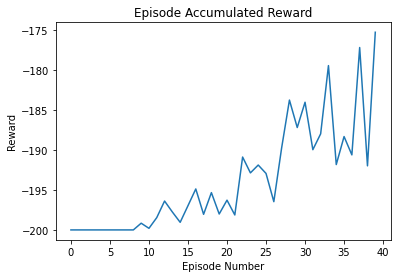

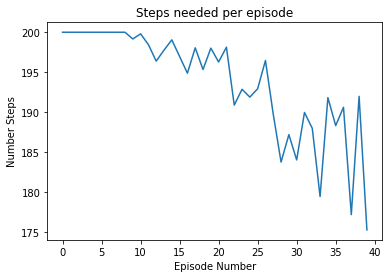

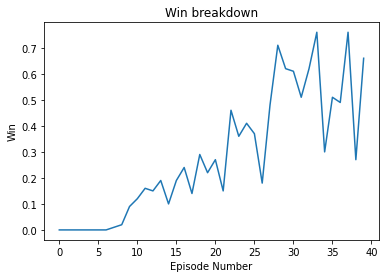

In [0]:
import matplotlib.pyplot as plt

# Average results every N timesteps for better visualization.
average_range = 100
episode_ticks = int(NUMBER_EPISODES / average_range)

avg_rewards = np.array(rewards).reshape((episode_ticks, average_range))
avg_rewards = np.mean(avg_rewards, axis=1)

avg_steps = np.array(steps).reshape((episode_ticks, average_range))
avg_steps = np.mean(avg_steps, axis=1)

avg_wins = np.array(wins).reshape((episode_ticks, average_range))
avg_wins = np.mean(avg_wins, axis=1)

# Plot

plt.plot(range(episode_ticks), avg_rewards)
plt.title("Episode Accumulated Reward")
plt.xlabel("Episode Number")
plt.ylabel("Reward")
plt.show()


plt.plot(range(episode_ticks), avg_steps)
plt.title("Steps needed per episode")
plt.xlabel("Episode Number")
plt.ylabel("Number Steps")
plt.show()


plt.plot(range(episode_ticks), avg_wins)
plt.title("Win breakdown")
plt.xlabel("Episode Number")
plt.ylabel("Win")
plt.show()

## Visualizacion del agente

Vamos a ejecutar una política completamente greedy para observar lo aprendido por el algoritmo, usando la q_table retornada por el mismo para decidir la mejor accion.


In [0]:
env = wrap_env(gym.make("MountainCar-v0"))

observation = env.reset()
position, velocity = discretization(env, observation)

while True:
    env.render()

    action = np.argmax(q_table[position][velocity])
    observation, reward, done, info = env.step(action) 
    
    position, velocity = discretization(env, observation)

    if done:
      break

env.close()
show_video()

del env

### Implementación de Sarsa


![Image](https://miro.medium.com/max/2612/1*Wim9wr-jYJtZyZ_4ZJRHNg.jpeg)

In [0]:
def sarsa(env, number_episodes=100, alpha=0.1, gamma=0.9, epsilon_start=0.9, epsilon_min=0.1, epsilon_decay=0.9):

  # Initialize Q_table as a matrix of NumberStatesxNumberStatesxNumberActions
  q_table = np.zeros((NUMBER_STATES, NUMBER_STATES, 3))

  # Initialize epsilon
  epsilon = epsilon_start
  
  # Stat trackers
  # Track the accumulated reward per episode
  episode_rewards = []
  # Track the number of steps taken in each episode
  episode_steps = []
  # Track the number of times we reach the goal (1 if we do, 0 otherwise)
  wins = []   

  for ep_idx in range(number_episodes):

    ep_reward = 0
    ep_steps = 0

    # Reset the environment and get initial position and velocity
    observation = env.reset()
    position, velocity = discretization(env, observation)

    # Epsilon greedy policy.
    action = np.argmax(q_table[position][velocity])
    if np.random.uniform() < epsilon:
      action = np.random.choice(env.action_space.n)
  
    done = False
    while not done:
    
      # Take action on env and observe result.
      new_observation, reward, done, info = env.step(action)
      ep_reward += reward
      ep_steps += 1
      new_position, new_velocity = discretization(env, new_observation)

      # Epsilon greedy policy.
      new_action = np.argmax(q_table[new_position][new_velocity])
      if np.random.uniform() < epsilon:
        new_action = np.random.choice(env.action_space.n)

      # Sarsa update rule.
      q_new_state = q_table[new_position][new_velocity][new_action]
      q_table[position][velocity][action] = q_table[position][velocity][action] + \
        alpha * ( reward + gamma * q_new_state - q_table[position][velocity][action])
      
      # Move the state & action forward.
      position = new_position
      velocity = new_velocity
      action = new_action
    
    # Count number of "wins" for mountain car env.
    if position >= 36:
      wins.append(1)
    else:
      wins.append(0)

    episode_rewards.append(ep_reward)
    episode_steps.append(ep_steps)

    # Update epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

  return q_table, episode_rewards, episode_steps, wins

In [0]:
env = gym.make("MountainCar-v0")
NUMBER_EPISODES = 4000
q_table, rewards, steps, wins = sarsa(env, number_episodes=NUMBER_EPISODES, alpha=0.3, epsilon_decay=0.5)

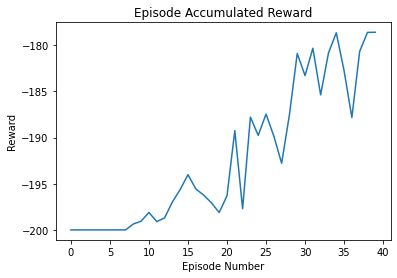

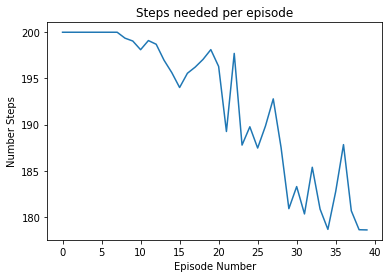

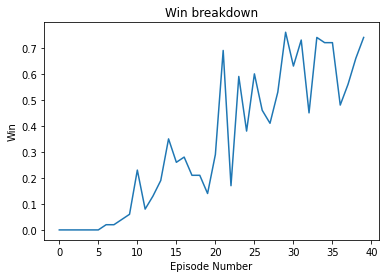

In [0]:
# Average results every N timesteps for better visualization.
average_range = 100
episode_ticks = int(NUMBER_EPISODES / average_range)

avg_rewards = np.array(rewards).reshape((episode_ticks, average_range))
avg_rewards = np.mean(avg_rewards, axis=1)

avg_steps = np.array(steps).reshape((episode_ticks, average_range))
avg_steps = np.mean(avg_steps, axis=1)

avg_wins = np.array(wins).reshape((episode_ticks, average_range))
avg_wins = np.mean(avg_wins, axis=1)

# Plot

plt.plot(range(episode_ticks), avg_rewards)
plt.title("Episode Accumulated Reward")
plt.xlabel("Episode Number")
plt.ylabel("Reward")
plt.show()


plt.plot(range(episode_ticks), avg_steps)
plt.title("Steps needed per episode")
plt.xlabel("Episode Number")
plt.ylabel("Number Steps")
plt.show()


plt.plot(range(episode_ticks), avg_wins)
plt.title("Win breakdown")
plt.xlabel("Episode Number")
plt.ylabel("Win")
plt.show()

In [0]:
env = wrap_env(gym.make("MountainCar-v0"))

observation = env.reset()
position, velocity = discretization(env, observation)

while True:
    env.render()

    action = np.argmax(q_table[position][velocity])
    observation, reward, done, info = env.step(action) 
    
    position, velocity = discretization(env, observation)

    if done:
      break

env.close()
show_video()

del env

In [0]:
env = gym.make("MountainCar-v0")
q_learning_rewards_avg = []
sarsa_rewards_avg = []
NUMBER_EPISODES = 4000

for i in range(10):
  q_table, rewards, steps, wins = q_learning(env, number_episodes=NUMBER_EPISODES, alpha=0.3, epsilon_decay=0.5)
  rew_avg = np.average(rewards)
  q_learning_rewards_avg.append(rew_avg)

for i in range(10):
  q_table, rewards, steps, wins = sarsa(env, number_episodes=NUMBER_EPISODES, alpha=0.3, epsilon_decay=0.5)
  rew_avg = np.average(rewards)
  sarsa_rewards_avg.append(rew_avg)

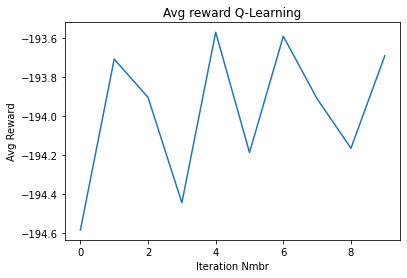

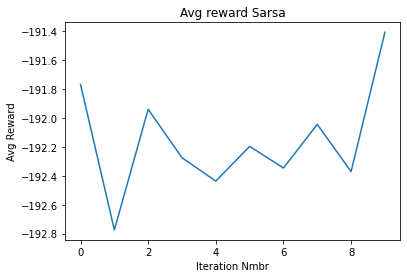

In [0]:
import matplotlib.pyplot as plt

plt.plot(range(10), q_learning_rewards_avg)
plt.title("Avg reward Q-Learning")
plt.xlabel("Iteration Nmbr")
plt.ylabel("Avg Reward")
plt.show()

plt.plot(range(10), sarsa_rewards_avg)
plt.title("Avg reward Sarsa")
plt.xlabel("Iteration Nmbr")
plt.ylabel("Avg Reward")
plt.show()

## Analysis

If we see both videos of the agent interacting with the environment using Q(s,a) estimates returned from Q-Learning and Sarsa, we can confirm Q-Learning performs much better than Sarsa. 

In the case of Q-Learning the agent tries to "climbs" the mountain 2 times and in Sarsa 3 times before reaching the goal.

This gives us the clue that Q estimates of pair (s,a) are much precise in Q-Learning rather than in Sarsa. The difference is introduced by updating estimates using the best action of the new state after step instead of using an e-greedy action to update the Q(s',a).